# The numbers behind Formula One champions

On this notebook, I will analise several statistics of Formula One's most succesfull drivers. The covered topics will be:
* The top 10 drivers with the most wins
* How the definition of a successfull driver changed over the years
* The influence the team has over a driver's success
* Longest streaks

For this analysis, I will be using ergast's database. More info about it can be found at http://ergast.com/mrd/

In [9]:
# Standart imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import requests

## Top 10 best drivers

In this section, we analyze the 10 drivers who won the most.

First, let's use the api to see which seasons it has data of.

In [10]:
response = requests.get(url="http://ergast.com/api/f1/seasons.json?limit=73&offset=0")
data = response.json()
list_of_seasons = []
for season in data["MRData"]["SeasonTable"]["Seasons"]:
    list_of_seasons.append(season["season"])
print(len(list_of_seasons))

73


F1's first season was back in 1950. So the database used has all seasons logged.

Now, let's see an example of how to get all the winners of a season, and then graph it.

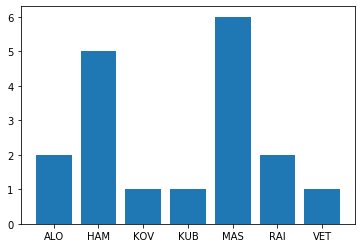

In [3]:
response = requests.get(url="http://ergast.com/api/f1/2008/results/1.json")
data = response.json()
winners_2008 = []
for race in data["MRData"]["RaceTable"]["Races"]:
    winners_2008.append(race["Results"][0]["Driver"]["code"])

drivers, nmbr_wins = np.unique(winners_2008, return_counts=True)
plt.bar(x=drivers, height=nmbr_wins, align="center");

So we see that Felipe Massa won one more race than Lewis Hamilton, but still lost the 2008 championship.

Now, let's try to do the same, but for every season in Formula 1.

In [4]:
year = 1950
winners_list = []
winners_dict = {}
for i in range(73):
    response = requests.get(url=f"http://ergast.com/api/f1/{year+i}/results/1.json")
    data = response.json()
    for race in data["MRData"]["RaceTable"]["Races"]:
        # Every time a driver wins, let's append his name to winners_list
        winners_list.append(race["Results"][0]["Driver"]["givenName"]+" "+race["Results"][0]["Driver"]["familyName"])
for driver in winners_list:
    # Each key on winners_dict will have a value of how many times that driver appears on winners_list
    winners_dict[driver] = winners_list.count(driver)
winners_dict

{'Nino Farina': 5,
 'Juan Fangio': 23,
 'Johnnie Parsons': 1,
 'Lee Wallard': 1,
 'José Froilán González': 2,
 'Alberto Ascari': 13,
 'Piero Taruffi': 1,
 'Troy Ruttman': 1,
 'Bill Vukovich': 2,
 'Mike Hawthorn': 3,
 'Maurice Trintignant': 2,
 'Bob Sweikert': 1,
 'Stirling Moss': 15,
 'Luigi Musso': 1,
 'Pat Flaherty': 1,
 'Peter Collins': 3,
 'Sam Hanks': 1,
 'Tony Brooks': 6,
 'Jimmy Bryan': 1,
 'Jack Brabham': 14,
 'Rodger Ward': 1,
 'Jo Bonnier': 1,
 'Bruce McLaren': 4,
 'Jim Rathmann': 1,
 'Phil Hill': 3,
 'Wolfgang von Trips': 2,
 'Giancarlo Baghetti': 1,
 'Innes Ireland': 1,
 'Graham Hill': 14,
 'Jim Clark': 25,
 'Dan Gurney': 4,
 'John Surtees': 6,
 'Lorenzo Bandini': 1,
 'Jackie Stewart': 27,
 'Richie Ginther': 1,
 'Ludovico Scarfiotti': 1,
 'Pedro Rodríguez': 2,
 'Denny Hulme': 8,
 'Jacky Ickx': 8,
 'Jo Siffert': 2,
 'Jochen Rindt': 6,
 'Clay Regazzoni': 5,
 'Emerson Fittipaldi': 14,
 'Mario Andretti': 12,
 'Peter Gethin': 1,
 'François Cevert': 1,
 'Jean-Pierre Beltoise': 1,

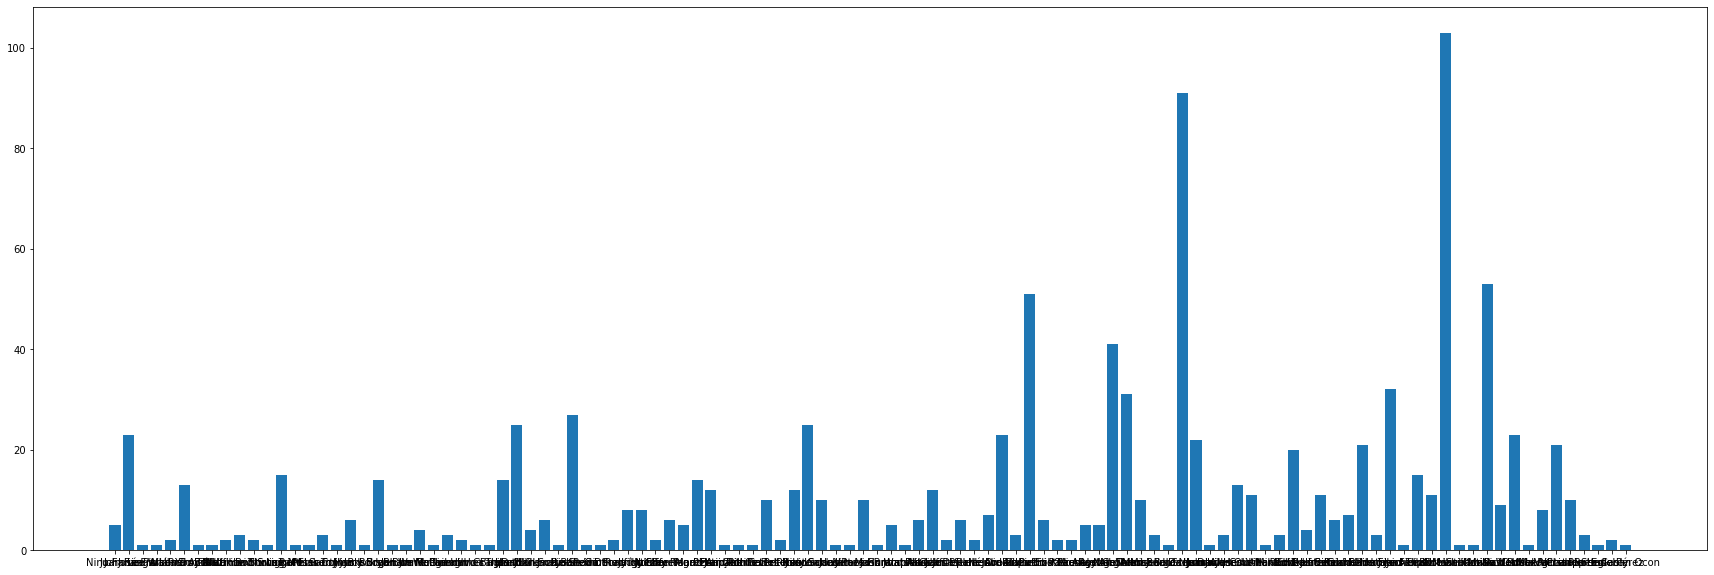

In [5]:
plt.subplots(figsize=(30,10))
plt.bar(x=winners_dict.keys(), height=winners_dict.values(), align="center");

In [6]:
# Making a DataFrame to make things clearer
driver_series = pd.Series(winners_dict.keys())
wins_series = pd.Series(winners_dict.values())
test = {
    "Drivers":driver_series,
    "Wins":wins_series
}
wincount_df = pd.DataFrame(test)
wincount_df

,Drivers,Wins
0,Nino Farina,5
1,Juan Fangio,23
2,Johnnie Parsons,1
3,Lee Wallard,1
4,José Froilán González,2
...,...,...
105,Valtteri Bottas,10
106,Charles Leclerc,3
107,Pierre Gasly,1
108,Sergio Pérez,2


In [7]:
# Now let's see the top 10 winners.
sorted_wincount_df = wincount_df.sort_values("Wins", ascending=False, axis=0)
top_10_df = sorted_wincount_df[:10]
top_10_df

,Drivers,Wins
96,Lewis Hamilton,103
77,Michael Schumacher,91
99,Sebastian Vettel,53
66,Alain Prost,51
72,Ayrton Senna,41
92,Fernando Alonso,32
73,Nigel Mansell,31
33,Jackie Stewart,27
50,Niki Lauda,25
29,Jim Clark,25


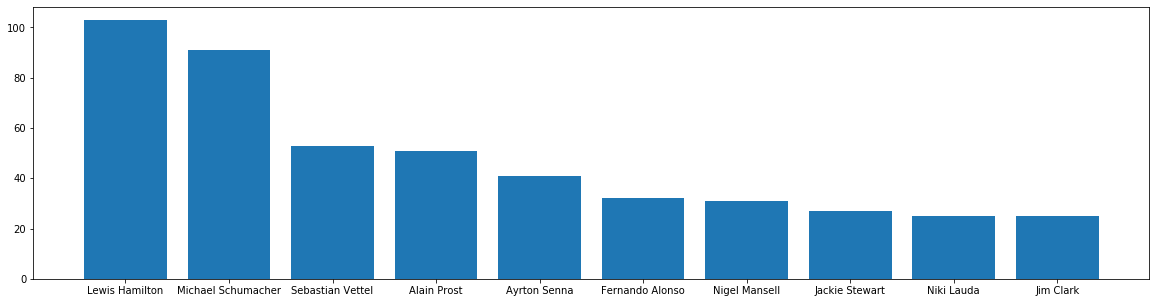

In [8]:
# Making a graph of these guys
plt.subplots(figsize=(20,5))
plt.bar(x=top_10_df.Drivers, height=top_10_df.Wins);

This graph shows us the 10 drivers who won the most races. With only this info at hand, one might say that these are the best drivers Formula 1 has ever had.

But this misses a critical point: How the sport changed over the years.

## How the definition of a succesfull driver changed over the years

To have a better understanding of how dominant a driver was, we need to consider the state of the sport back when they were driving.

### Races per season

This is probably the most important factor. Lewis Hamilton and Michael Schumacher would probably have a much harder time getting 90~100 race wins back in 1980, as back then there were only 14 races per season.

With this in mind, let's see how the number of races per season has changed over the years.

In [16]:
year = 1950
# Let's use a dictionary to store this data
races_per_season = {}
# This time we don't want to include the 2022 season, as it is not over. So, range(72).
for i in range(72):
    response = requests.get(url=f"http://ergast.com/api/f1/{year+i}/results/1.json")
    data = response.json()
    races_per_season[year+i] = 0
    for race in data["MRData"]["RaceTable"]["Races"]:
        races_per_season[year+i] += 1

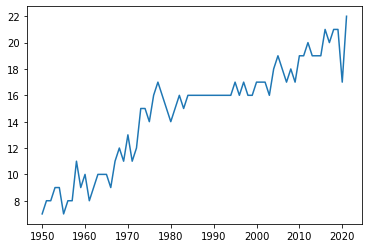

In [17]:
plt.plot(list(races_per_season.keys()), list(races_per_season.values()));

Notice the upward trend. In the first decades, there were barely 10 races a year. If Hamilton where to get his 100 wins back then, he would need to win a decade's worth of championships first.

This is why well-known drivers such as Juan Fangio or Alberto Ascari are not in the top 10: They simply did not have enough races per season to do so. This makes it even more impressive when someone who raced in those years, such as Niki Lauda or Jim Clark, does appear in the top 10.

Sidenote: Notice how covid-19 impacted the graph during the 2020 season: We went back to having as many races as we had back in the late 2000s.

### Average driver age throughout the years

It is important to analyze this data, as every sporstsmen has an "expiration date"; when their bodies simply aren't up to the task anymore. Which means that the earlier someone starts at F1, the more races they can have before retiring. 

This wasn't really a concern back in the 50s, as the sport was still growing, and every driver was old enough to be a dad. Nowadays, the 2021 champion started on F1 when he was just 17 years old. And he started go-karting when he was just 4 years old.

To analyze this data, we will analyze two averages: The average of the whole grid, and the average of the championship winner.

To prevent the code from running for 3 minutes, we will not analyze the age of all drivers in all the races of a season. Instead, we will only look at the Monaco Grand-Prix, as it has happened every season, and then draw the average for the whole year from there.